In [8]:
import sys
sys.path.append('..')
import argparse
import seaborn as sns
import datasets
import numpy as np
import torch
import pandas as pd
import transformers
from tqdm.notebook import tqdm, trange
from data import get_data, TASKS

import matplotlib.pyplot as plt
from model_utils.prompt_classification import test_model_on_task_with_prefix
import pickle as pkl

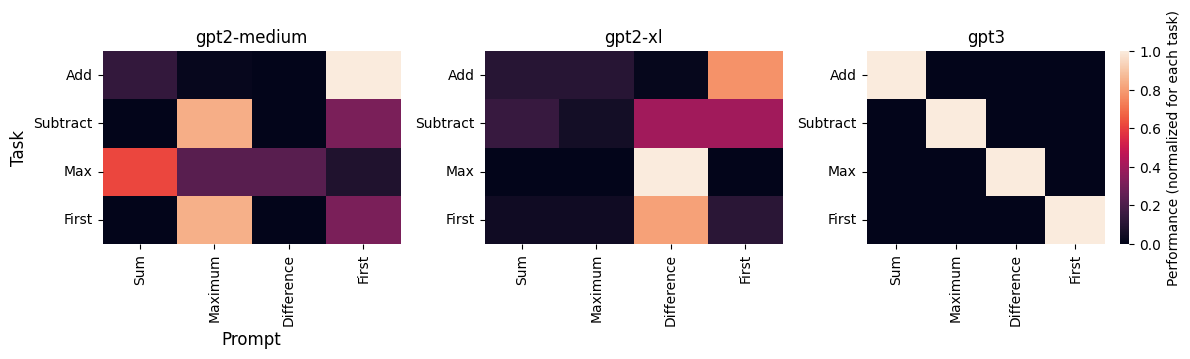

In [22]:
# model_names = ['gpt2-medium', 'EleutherAI/gpt-j-6B']
model_names = ['gpt2-medium', 'gpt2-xl', 'gpt3']
plt.figure(figsize=(12, 3.5))
for i, model_name in enumerate(model_names):
    # model_name = 'gpt2-medium'
    r = pkl.load(
        open(f'../results/prompt_classification/heatmap_{model_name.replace("/", "___")}.pkl', 'rb'))

    tasks_plot = ['add_two', 'subtract_two', 'max_two', 'first_two']
    task_names = r['task_names']
    idxs = np.array([task_names.index(task_names[i]) for i in range(len(task_names))
                     if task_names[i] in tasks_plot
                     ])

    plt.subplot(1, len(model_names), i + 1)

    # losses
    # losses = r['losses']
    # losses = torch.tensor(losses)
    # losses = losses[idxs, :][:, idxs]
    # losses = losses.softmax(axis=1)
    # task_descriptions = np.array(r['task_descriptions'])[idxs]
    # sns.heatmap(losses.softmax, yticklabels=tasks_plot,
    #             xticklabels=task_descriptions,
    #             cbar_kws={'label': 'Loss (normalized for each task)'})
    # plt.xticks(rotation=90)
    # plt.yticks(rotation=0)

    accuracies = r['accuracies']
    accuracies = accuracies[idxs, :][:, idxs]
    task_descriptions = np.array(r['task_descriptions'])[idxs]

    # print(r['losses'])
    # plt.subplot(122)
    # accuracies = torch.tensor(accuracies)
    accuracies = torch.tensor(accuracies).softmax(dim=1)
    plt.title(model_name)
    ax = sns.heatmap(accuracies,
                yticklabels=pd.Series(tasks_plot).apply(
                    lambda x: x.split('_')[0].capitalize()),
                xticklabels=pd.Series(task_descriptions).apply(
                    lambda x: x.split(' ')[2].capitalize()),
                cbar_kws={'label': 'Performance (normalized for each task)'},
                cbar= (i == len(model_names) - 1),
                square=True,
                # cbar_kws={'label': 'Accuracy (higher better)'}
                )
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    if i == 0:
        ax.set_ylabel('Task', fontsize='large')
        ax.set_xlabel('Prompt', fontsize='large') 
    plt.tight_layout()
plt.savefig('../results/prompt_classification/heatmaps_prompt_classification.pdf',
            bbox_inches='tight')


In [32]:
losses[0].softmax(dim=0)

tensor([0., 0., 0., 1.], dtype=torch.float64)

## look at individual example

Note on division: division task looks like “{prefix} Given the numbers 9 and 3, the answer is 9/3” and since it’s just next token prediction the model just needs to predict the 9, not the full 9/3. So the fact that “return the first of the inputs” is the best prompt makes a lot of sense

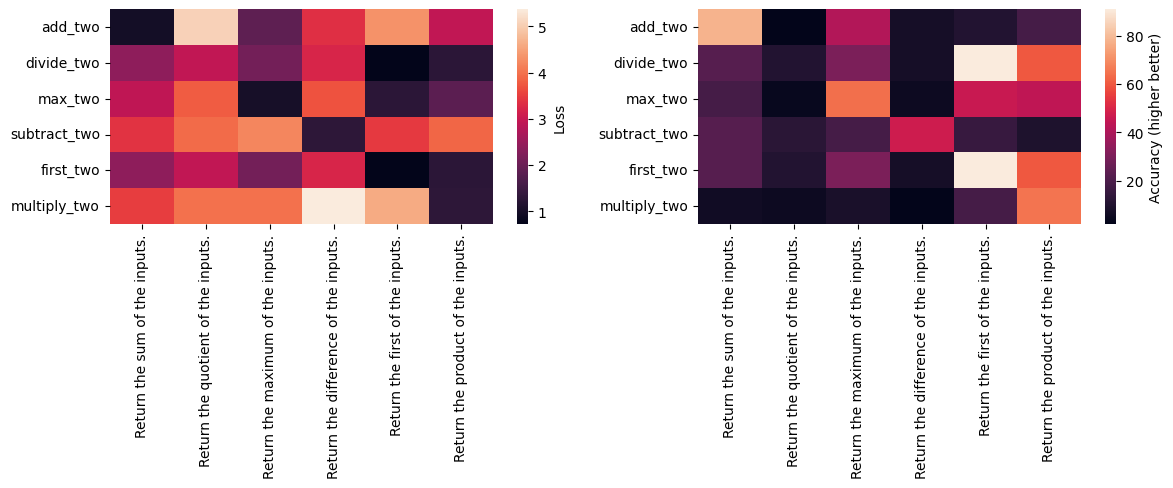

In [4]:
model_name = 'EleutherAI/gpt-j-6B'
# model_name = 'gpt2-medium'
r = pkl.load(open(f'results/heatmap_{model_name.replace("/", "___")}.pkl', 'rb'))

# sns.set()
plt.figure(figsize=(12, 5))
plt.subplot(121)
sns.heatmap(r['losses'], yticklabels=r['task_names'],
            xticklabels=r['task_descriptions'], cbar_kws={'label': 'Loss'})
# sns.heatmap(torch.tensor(losses).softmax(dim=1), yticklabels=task_names,
            # xticklabels=task_descriptions, cbar_kws={'label': 'Loss, normalized (lower better)'})

plt.subplot(122)
sns.heatmap(torch.tensor(r['accuracies']), yticklabels=r['task_names'],
            xticklabels=r['task_descriptions'], cbar_kws={'label': 'Accuracy (higher better)'})
plt.tight_layout()


# Test classification

Do a simple test

In [2]:
args_dict = {
    'max_dset_size': 10_000,
    'template_num_task_phrasing': 0,
    'n_shots': 1,
    'max_digit': 10,
}
args = argparse.Namespace(**args_dict)

task_names = TASKS.keys()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'gpt2-medium'
# model_name = 'EleutherAI/gpt-j-6B' # 'EleutherAI/gpt-neox-20b'
batch_size = 1

# load stuff
model = transformers.AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=False)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, output_hidden_states=False)


task_name = 'square_one'
prefix = f'asldjfo the following numbers. '
dset, check_answer_func, description = get_data(args=args, task_name=task_name)
test_model_on_task_with_prefix(dset=dset, model=model, tokenizer=tokenizer, prefix=prefix, batch_size=batch_size)

[('asldjfo the following numbers. Given the input x is 6, the output f(x) is', ' 36.\n\n')]


(3.367671237885952, 20.0)

Loop and check the tasks

In [ ]:
task_information = {}
task_descriptions = []
task_names = ['add_two', 'divide_two', 'max_two', 'subtract_two', 'first_two', 'multiply_two']
# task_names = ['add_two', 'multiply_two', 'divide_two', 'subtract_two', 'max_two', 'first_two', 'SUFFIXES', 'square_one', 'exp_one', 'prime_one', 'double_one', 'fibonacci_one']
# task_names = list(set(TASKS.keys()) - {'SUFFIXES'})

for name in task_names:
    # print(name)
    dset, check_answer_func, description = get_data(args=args, task_name=name)
    task_descriptions.append(description)
    
task_descriptions

In [ ]:
Note on division: division task looks like “{prefix} Given the numbers 9 and 3, the answer is 9/3” and since it’s just next token prediction the model just needs to predict the 9, not the full 9/3. So the fact that “return the first of the inputs” is the best prompt makes a lot of sense

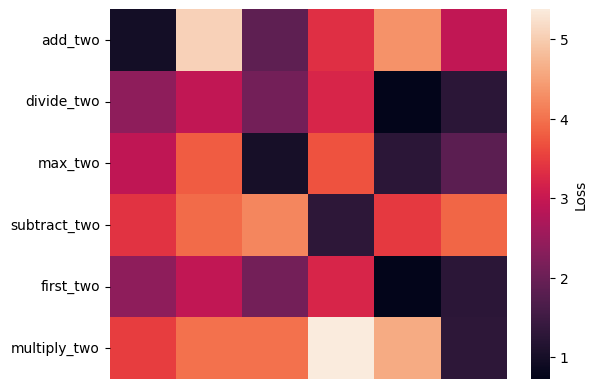

In [8]:
sns.heatmap(losses, yticklabels=task_names,
            xticklabels=task_descriptions, cbar_kws={'label': 'Loss'})
plt.savefig(f'figs/heatmap_{model_name.replace("/", "___")}')